In [1]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# 파일 불러오기

In [2]:
data_merge = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\ver_3_merge_data.csv")
data_merge

,base_date,emd_cd,korean,long_term_frgn,short_term_frgn,resident,card_cnt,card_amt,waste_cnt,detached,apt,town,multiplex,commercial_building,distancing,waste_amt
0,2019-11-30,50110250,7.321788e+06,469689.3527,129161.4006,25149,267.380645,9586590.265,620,60578,58244,18880,28829,3900,0.000000,2279550
1,2019-12-31,50110250,6.915173e+06,482920.2385,122124.6609,25080,266.814465,9621756.255,8178,60578,58244,18880,28829,3900,0.000000,31493650
2,2020-01-31,50110250,7.476137e+06,587299.9640,112758.3034,25076,257.604430,9648302.136,13042,5542,954,1085,608,277,0.000000,49632850
3,2020-02-29,50110250,5.561978e+06,559439.3959,60252.7989,25021,249.621160,8760701.457,12264,5542,954,1085,608,277,0.000000,46197050
4,2020-03-31,50110250,6.094369e+06,714445.0812,29661.4429,24942,261.877023,8979547.945,14316,5542,954,1085,608,277,0.000000,52561750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,2021-02-28,50130620,4.321265e+06,109325.4866,280.6159,4173,65.216000,2463788.712,4563,1023,0,219,39,29,1.750000,15566250
1630,2021-03-31,50130620,4.744309e+06,118258.8891,1475.8404,4178,67.700000,2572585.700,4920,1023,0,219,39,29,1.500000,17300600
1631,2021-04-30,50130620,5.236706e+06,129227.7480,1283.0997,4161,68.642336,2473174.901,5256,1023,0,219,39,29,1.500000,17646850
1632,2021-05-31,50130620,5.805413e+06,144213.2650,1212.2652,4178,69.333333,2864493.949,6346,1023,0,219,39,29,1.532258,19494750


# xgboost 모델링

In [3]:
X_features = data_merge.loc[:, ['korean', 'long_term_frgn', 'short_term_frgn', 'resident', 
                                'card_cnt', 'card_amt', 'waste_cnt',
                                'detached', 'apt', 'town', 'multiplex', 'commercial_building', 'distancing']]
y_label = data_merge.loc[:, 'waste_amt']

In [4]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(1307, 13) (327, 13)


In [5]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [6]:
# max_depth = 3, 학습률은 0.1, 목적함수(objective)는 reg:linear(회귀)
# 오류함수의 평가성능지표는 rmse
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 7,
         'eta' : 0.1, 
         'objective' : 'reg:linear',
         'eval_metric' : 'rmsle',
         'early_stoppings' : 100 }
num_rounds = 1000

In [7]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[01:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmsle:2.31301	eval-rmsle:2.31622
[1]	train-rmsle:1.67142	eval-rmsle:1.67385
[2]	train-rmsle:1.31484	eval-rmsle:1.31754
[3]	train-rmsle:1.07761	eval-rmsle:1.07891
[4]	train-rmsle:0.90357	eval-rmsle:0.90354
[5]	train-rmsle:0.76857	eval-rmsle:0.76798
[6]	train-rmsle:0.66110	eval-rmsle:0.66046
[7]	train-rmsle:0.57421	eval-rmsle:0.57564
[8]	train-rmsle:0.50170	eval-rmsle:0.50499
[9]	train-rmsle:0.44091	eval-rmsle:0.4447

[172]	train-rmsle:0.02243	eval-rmsle:0.07969
[173]	train-rmsle:0.02242	eval-rmsle:0.07969
[174]	train-rmsle:0.02234	eval-rmsle:0.07969
[175]	train-rmsle:0.02223	eval-rmsle:0.07970
[176]	train-rmsle:0.02222	eval-rmsle:0.07970
[177]	train-rmsle:0.02220	eval-rmsle:0.07969
[178]	train-rmsle:0.02222	eval-rmsle:0.07965
[179]	train-rmsle:0.02218	eval-rmsle:0.07974
[180]	train-rmsle:0.02219	eval-rmsle:0.07980
[181]	train-rmsle:0.02219	eval-rmsle:0.07980
[182]	train-rmsle:0.02213	eval-rmsle:0.07978
[183]	train-rmsle:0.02152	eval-rmsle:0.07982
[184]	train-rmsle:0.02147	eval-rmsle:0.07988
[185]	train-rmsle:0.02142	eval-rmsle:0.07989
[186]	train-rmsle:0.02140	eval-rmsle:0.07990
[187]	train-rmsle:0.02099	eval-rmsle:0.07982
[188]	train-rmsle:0.02088	eval-rmsle:0.07981
[189]	train-rmsle:0.02090	eval-rmsle:0.07980
[190]	train-rmsle:0.02094	eval-rmsle:0.07976
[191]	train-rmsle:0.02084	eval-rmsle:0.07979
[192]	train-rmsle:0.02084	eval-rmsle:0.07979
[193]	train-rmsle:0.02079	eval-rmsle:0.07975
[194]	trai

[355]	train-rmsle:0.00875	eval-rmsle:0.07928
[356]	train-rmsle:0.00853	eval-rmsle:0.07929
[357]	train-rmsle:0.00843	eval-rmsle:0.07929
[358]	train-rmsle:0.00840	eval-rmsle:0.07929
[359]	train-rmsle:0.00836	eval-rmsle:0.07928
[360]	train-rmsle:0.00834	eval-rmsle:0.07928
[361]	train-rmsle:0.00833	eval-rmsle:0.07932
[362]	train-rmsle:0.00829	eval-rmsle:0.07933
[363]	train-rmsle:0.00827	eval-rmsle:0.07933
[364]	train-rmsle:0.00824	eval-rmsle:0.07933
[365]	train-rmsle:0.00824	eval-rmsle:0.07933
[366]	train-rmsle:0.00821	eval-rmsle:0.07931
[367]	train-rmsle:0.00817	eval-rmsle:0.07929
[368]	train-rmsle:0.00816	eval-rmsle:0.07930
[369]	train-rmsle:0.00814	eval-rmsle:0.07930
[370]	train-rmsle:0.00808	eval-rmsle:0.07930
[371]	train-rmsle:0.00808	eval-rmsle:0.07931
[372]	train-rmsle:0.00782	eval-rmsle:0.07931
[373]	train-rmsle:0.00780	eval-rmsle:0.07931
[374]	train-rmsle:0.00770	eval-rmsle:0.07928
[375]	train-rmsle:0.00768	eval-rmsle:0.07928
[376]	train-rmsle:0.00765	eval-rmsle:0.07926
[377]	trai

[538]	train-rmsle:0.00268	eval-rmsle:0.07914
[539]	train-rmsle:0.00268	eval-rmsle:0.07914
[540]	train-rmsle:0.00266	eval-rmsle:0.07914
[541]	train-rmsle:0.00266	eval-rmsle:0.07916
[542]	train-rmsle:0.00263	eval-rmsle:0.07916
[543]	train-rmsle:0.00263	eval-rmsle:0.07918
[544]	train-rmsle:0.00263	eval-rmsle:0.07918
[545]	train-rmsle:0.00261	eval-rmsle:0.07917
[546]	train-rmsle:0.00260	eval-rmsle:0.07918
[547]	train-rmsle:0.00259	eval-rmsle:0.07918
[548]	train-rmsle:0.00258	eval-rmsle:0.07918
[549]	train-rmsle:0.00257	eval-rmsle:0.07918
[550]	train-rmsle:0.00256	eval-rmsle:0.07918
[551]	train-rmsle:0.00249	eval-rmsle:0.07917
[552]	train-rmsle:0.00246	eval-rmsle:0.07917
[553]	train-rmsle:0.00246	eval-rmsle:0.07917
[554]	train-rmsle:0.00244	eval-rmsle:0.07917
[555]	train-rmsle:0.00243	eval-rmsle:0.07917
[556]	train-rmsle:0.00242	eval-rmsle:0.07917
[557]	train-rmsle:0.00240	eval-rmsle:0.07917
[558]	train-rmsle:0.00240	eval-rmsle:0.07917
[559]	train-rmsle:0.00239	eval-rmsle:0.07917
[560]	trai

[721]	train-rmsle:0.00112	eval-rmsle:0.07912
[722]	train-rmsle:0.00112	eval-rmsle:0.07912
[723]	train-rmsle:0.00112	eval-rmsle:0.07912
[724]	train-rmsle:0.00112	eval-rmsle:0.07912
[725]	train-rmsle:0.00111	eval-rmsle:0.07912
[726]	train-rmsle:0.00110	eval-rmsle:0.07912
[727]	train-rmsle:0.00110	eval-rmsle:0.07912
[728]	train-rmsle:0.00109	eval-rmsle:0.07911
[729]	train-rmsle:0.00108	eval-rmsle:0.07911
[730]	train-rmsle:0.00108	eval-rmsle:0.07911
[731]	train-rmsle:0.00107	eval-rmsle:0.07911
[732]	train-rmsle:0.00107	eval-rmsle:0.07911
[733]	train-rmsle:0.00107	eval-rmsle:0.07911
[734]	train-rmsle:0.00105	eval-rmsle:0.07911
[735]	train-rmsle:0.00103	eval-rmsle:0.07911
[736]	train-rmsle:0.00103	eval-rmsle:0.07911
[737]	train-rmsle:0.00103	eval-rmsle:0.07911
[738]	train-rmsle:0.00102	eval-rmsle:0.07911
[739]	train-rmsle:0.00102	eval-rmsle:0.07911
[740]	train-rmsle:0.00102	eval-rmsle:0.07911
[741]	train-rmsle:0.00101	eval-rmsle:0.07911
[742]	train-rmsle:0.00100	eval-rmsle:0.07912
[743]	trai

[903]	train-rmsle:0.00040	eval-rmsle:0.07914
[904]	train-rmsle:0.00040	eval-rmsle:0.07914
[905]	train-rmsle:0.00040	eval-rmsle:0.07914
[906]	train-rmsle:0.00040	eval-rmsle:0.07914
[907]	train-rmsle:0.00040	eval-rmsle:0.07914
[908]	train-rmsle:0.00040	eval-rmsle:0.07914
[909]	train-rmsle:0.00040	eval-rmsle:0.07914
[910]	train-rmsle:0.00040	eval-rmsle:0.07914
[911]	train-rmsle:0.00039	eval-rmsle:0.07914
[912]	train-rmsle:0.00039	eval-rmsle:0.07914
[913]	train-rmsle:0.00039	eval-rmsle:0.07914
[914]	train-rmsle:0.00039	eval-rmsle:0.07914
[915]	train-rmsle:0.00039	eval-rmsle:0.07914
[916]	train-rmsle:0.00039	eval-rmsle:0.07914
[917]	train-rmsle:0.00039	eval-rmsle:0.07914
[918]	train-rmsle:0.00039	eval-rmsle:0.07914
[919]	train-rmsle:0.00038	eval-rmsle:0.07914
[920]	train-rmsle:0.00038	eval-rmsle:0.07914
[921]	train-rmsle:0.00038	eval-rmsle:0.07914
[922]	train-rmsle:0.00038	eval-rmsle:0.07914
[923]	train-rmsle:0.00038	eval-rmsle:0.07914
[924]	train-rmsle:0.00037	eval-rmsle:0.07914
[925]	trai

# 예측하기

In [8]:
pred_probs = xgb_model.predict(dtest)
pred_probs

array([1.14727430e+07, 1.87471616e+08, 2.68431000e+07, 2.35485296e+08,
       4.32578240e+07, 3.58806560e+07, 6.59573760e+07, 4.04774160e+07,
       1.02916688e+08, 1.00196896e+08, 1.04959600e+08, 1.02680904e+08,
       5.93610760e+07, 3.48249720e+07, 4.76780240e+07, 4.69179840e+07,
       3.67213400e+07, 2.52855840e+08, 5.27341520e+07, 6.92051280e+07,
       5.17660160e+07, 9.07305680e+07, 5.56927560e+07, 4.09478280e+07,
       5.18212200e+07, 3.21593440e+07, 3.64575120e+07, 2.05364780e+07,
       3.35271540e+07, 5.13947800e+07, 2.67016820e+07, 3.84493280e+07,
       5.86530760e+07, 1.45244352e+08, 1.61015000e+07, 1.12658950e+07,
       1.07732176e+08, 2.09073520e+08, 1.56712310e+07, 9.27658240e+07,
       3.95253200e+07, 3.02439500e+07, 1.47452580e+07, 7.11179120e+07,
       2.52205400e+07, 2.17480780e+07, 3.86628000e+06, 9.77786400e+07,
       4.05154960e+07, 1.65989660e+07, 2.40731060e+07, 5.29179520e+07,
       6.13677960e+07, 1.42386800e+07, 3.50946120e+07, 3.00106180e+07,
      

In [9]:
pd.DataFrame(pred_probs)

,0
0,11472743.0
1,187471616.0
2,26843100.0
3,235485296.0
4,43257824.0
...,...
322,43712472.0
323,20545936.0
324,40420680.0
325,106803808.0


In [10]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [12]:
get_clf_eval(y_test, pred_probs)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

# feature importance 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

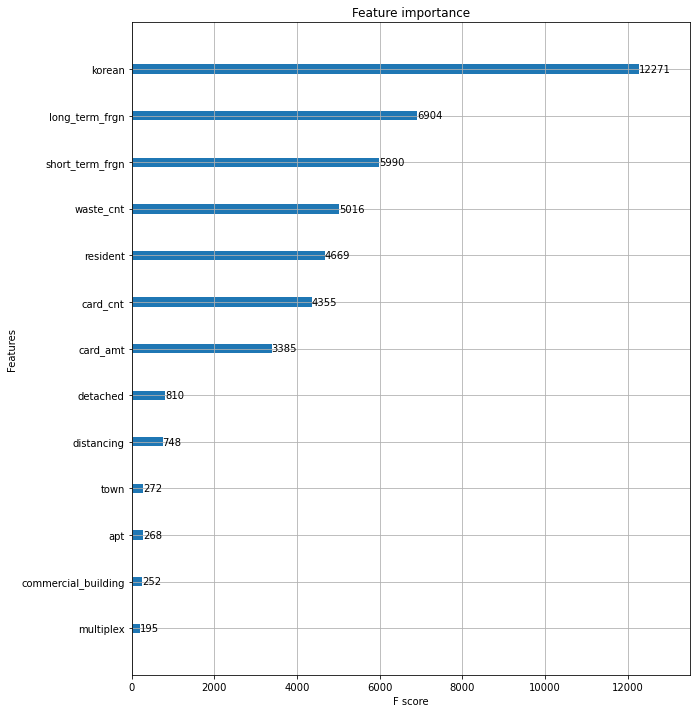

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)